## Shallow Neural Networks


> Pacotes necessários

In [1]:
import numpy as np
import os

import scipy
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import importlib

from time import monotonic as timer

> Esta célula trata dos plots dos datasets com e sem preditions e a função que trata de fazer o parse do dataset

In [2]:
def plot_data(row,col,n_row,n_col,data):
    fig=plt.figure(figsize=(row,col))
    for n in range(1, row*col +1):
        img=np.reshape(data[n-1][:-1],(n_row,n_col))
        fig.add_subplot(row, col, n)
        plt.imshow(img,interpolation='none',cmap='binary')
    plt.show()
    
def plot_tagged_data(row,col,n_row,n_col,X,Y,parameters,activation_function): 
    fig=plt.figure(figsize=(row,col))
    
    l,cache = feed_forward(X.T,parameters,activation_function)
    for n in range(row*col):
        img=np.reshape(X[n],(n_row,n_col))
        fig.add_subplot(row, col, n+1)
           
        if(l[0][n]>0.5):
    
            plt.imshow(img,interpolation='none',cmap='RdPu')
        else:
            plt.imshow(img,interpolation='none',cmap='cool')               
    plt.show()
    
def read_asc_data(filename):    
    f= open(filename,'r') 
    tmp_str=f.readline()
    tmp_arr=tmp_str[:-1].split(' ')
    N=int(tmp_arr[0]);n_row=int(tmp_arr[1]);n_col=int(tmp_arr[2])
    data=np.zeros([N,n_row*n_col+1])
    for n in range(N):
        tmp_str=f.readline()
        tmp_arr=tmp_str[:-1].split(' ')       
        for i in range(n_row*n_col+1):
            data[n][i]=int(tmp_arr[i])
    f.close() 
    return N,n_row,n_col,data

> Esta célula corre todas as funções de ativação e as suas derivadas

In [3]:
# sigmoid function
def sigmoid(z):
    s = 1 / (1 + np.exp(-z));
    return s;

# relu function
def relu(z):
    return np.where( z <= 0, 0 , z)

# swish function
def swish(z):
    s = z / (1 + np.exp(-z));
    return s;

#derivada swish
def der_swish(z):
    return (sigmoid(z)+z*sigmoid(1-sigmoid(z)))


#derivada sigmoid
def der_sigmoid(z):
    return sigmoid(1-sigmoid(z))

#derivada tangente hiperbólica
def der_tanh(z):
    return (1-np.power(z,2))

#derivada relu
def der_relu(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

#leaky_relu function
def leaky_relu(z):
    return np.where( z <= 0, 0.01*z, z)

#derivada leaky_relu
def der_leaky_relu(z):
    z[z<=0]=0.01
    z[z>0]=1
    return z

#normalization
def normalization(ew):
    return(ew/np.linalg.norm(ew,2))

> Esta célula inicializa os parãmetros de uma rede neuronal, neste caso temos apenas dois layers

> Input -> Hidden Layer -> Output


In [4]:
# size of the fst and the last layer, and the hidden layer
# assuming 1 hidden layer
def inicializar_parameters(n_x,n_h,n_y,xor=False):
    
    #w1 = np.zeros((n_h,n_x))
    #w1 = normalization(w1)
    w1 = np.random.randn(n_h,n_x) * 0.01;
    b1 = np.zeros((n_h,1));
    
    #w2 = np.zeros((n_y,n_h))
    #w2 = normalization(w2)
    w2 = np.random.randn(n_y,n_h) * 0.01;
    b2 = np.zeros((n_y,1));
    
    
    if(xor == True):
        w1 = np.ones(shape=(n_h,n_x))
        b1 = np.zeros((n_h,1))
        w2 = np.ones(shape=(n_y,n_h))
        b2 = np.zeros((n_y,1))
        
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters;


> Esta célula faz o feed forward da rede, neste caso temos que especificar as funções de ativação

> Input -> Função linear(z1) -> Função de Ativação -> Função linear(Z2) -> Função de Ativação(Sigmoid) (output)

In [5]:
# i use the non-linear activation function called than, in the output layer i use sigmoid, cause this is a binary classification problem.
def feed_forward(X,parameters,activation):
    
    
    w1 = parameters["w1"];
    b1 = parameters["b1"];
    w2 = parameters["w2"];
    b2 = parameters["b2"];

    #feed_foward
    Z1 = np.dot(w1,X) + b1; 

    if(activation == "tanh"):
        A1 = np.tanh(Z1);
    elif(activation == "relu"):
        A1 = relu(Z1);
    elif(activation == "sigmoid"):
        A1 = sigmoid(Z1);
    elif(activation == "leaky_relu"):
        A1 = leaky_relu(Z1);
    elif(activation == "swish"):
        A1 = swish(Z1);
        
    Z2 = np.dot(w2,A1) + b2;
    A2 = sigmoid(Z2);

    cache = {
        "Z1" : Z1,
        "A1" : A1,
        "Z2" : Z2,
        "A2" : A2
    }

    return A2, cache;

> Função custo

In [6]:
def calculate_cost(A2,Yt):
    #para não estar a fazer log de 0 acrescenta-se um eta
    e = 1e-8
    m = A2.shape[1]
    Cost = - np.sum(np.dot(Yt, np.log(A2+e).T) + np.dot(1 - Yt, np.log(1 - A2+e).T)) /m;  #cost function
    return Cost;


> Back propagation da rede, preciso as funções de ativação

In [7]:
def back_propagation(X,Y,cache,parameters,activation):
    

    m = Y.shape[1]    
    A1 = cache["A1"];
    w1 = parameters["w1"];
    w2 = parameters["w2"];
    A2 = cache["A2"];
    
    dZ2 = A2 - Y;
    dW2 = np.dot(dZ2,A1.T)/m;
    dB2 = np.sum(dZ2, axis=1, keepdims = True)/m;
    
    if(activation == "relu"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_relu(A1));
    if(activation == "tanh"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), 1 - np.power(A1, 2));
    if(activation == "sigmoid"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2),der_sigmoid(A1));
    if(activation == "leaky_relu"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_leaky_relu(A1));
    if(activation == "swish"):
        dZ1 = np.multiply(np.dot(w2.T,dZ2), der_swish(A1));
        
    dW1 = np.dot(dZ1,X.T)/m;
    dB1 = np.sum(dZ1,axis = 1, keepdims = True)/m;

    grads = {
        "dW2" : dW2,
        "dB2" : dB2,
        "dW1" : dW1,
        "dB1" : dB1
    }

    return grads;


> Otimização de parâmetros, feito após ter corrido o back propagation, e obtido os respetivos gradientes

In [8]:
def otimize_parameters(parameters,grads,learning_rate):
    
    w1 = parameters["w1"];
    w2 = parameters["w2"];
    b1 = parameters["b1"];
    b2 = parameters["b2"];

    
    dW2 = grads["dW2"];
    dB2 = grads["dB2"];
    dW1 = grads["dW1"];
    dB1 = grads["dB1"];

    #uptade de parameters
    w2 = w2 - learning_rate * dW2;
    w1 = w1 - learning_rate * dW1;
    b1 = b1 - learning_rate * dB1;
    b2 = b2 - learning_rate * dB2;

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters;

> Esta célula reparte o dataset em vários batches

In [9]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    inputs = inputs.T
    targets = targets.T
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

> Modelo

In [15]:
def model(n_h,epochs,learning_rate,activation,batch_size,show_info,shuffle=True):

    np.random.seed(4) # we set up a seed so that your output matches ours although the initialization is random.
    parameters = inicializar_parameters(Xt.shape[0],n_h,Yt.shape[0],xor=False);
    
    #previous_cost vai ser similar a um eraly stopping neste problema, qd o custo não diminuir em 100 epochs para de treinar
    previous_cost = 1e3
    previous_val_accuracy = 1
    cost_arr=[]
    costval_arr=[]
    acc_train = []
    acc_val = []
    
    times = []#array with the times of each epoch
    
    for i in range(0,epochs):
        
        begin = timer()
        
        
        for batch in iterate_minibatches(Xt, Yt, batch_size, shuffle=True):
            
            x_batch, y_batch = batch
            
        
            A2, cache = feed_forward(x_batch.T,parameters,activation);
            grads = back_propagation(x_batch.T,y_batch.T,cache,parameters,activation);
            parameters = otimize_parameters(parameters,grads,learning_rate);            
        
            #calculate the time in seconds
        end = timer()
        time = end-begin
        times.append(time)
        
        
        if(i%100 == 0):
            
            #validation cost calcultated here
            A2_train, _ = feed_forward(Xt,parameters,activation);
            A2_val, _ = feed_forward(Xval,parameters,activation);
            
            A2_val_plot = np.where(A2_val >= 0.5, 1 , 0)
            A2_plot = np.where(A2_train >= 0.5, 1 , 0)
            
            accuracy_train = np.sum(np.equal(A2_plot,Yt))/(A2_train.shape[1])
            accuracy_val = np.sum(np.equal(A2_val_plot,Yval))/(A2_val.shape[1])
            
            acc_train.append(accuracy_train)
            acc_val.append(accuracy_val)
            
            
            cost = calculate_cost(A2_train,Yt)
            if(show_info == True):
                print("Cost of iteration " + str(i) + " = " + str(cost) + " and accuracy train of = " + str(accuracy_train));
            costval = calculate_cost(A2_val,Yval)
            if(show_info == True):
                print("Cost of validation iteration " + str(i) + " = " + str(costval) + " and accuracy val of = " + str(accuracy_val));
            
            #parar se o cost em 100 iterações doir maior ao igual que o de -100 iterações
            if(cost >= previous_cost or (accuracy_train == 1 or accuracy_val == 1)):
                break

            previous_cost = cost
            cost_arr.append(cost)
            costval_arr.append(costval)
    
    if(show_info == True):
        figure(figsize=(15, 5))
        #primeiros dois números são as shapes,  linha e coluna, 3 index é onde está o gráfico
        plt.subplot(1, 2, 1)
        plt.plot(cost_arr)
        plt.plot(costval_arr)
        plt.title('model cost')
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.legend(['train', 'test'], loc='upper left')
    

        plt.subplot(1, 2, 2)    
        plt.plot(acc_train)
        plt.plot(acc_val)
        plt.title('model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('iteration')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    return cache,parameters,times,accuracy_train,accuracy_val,i

find 600 images of 8 X 8 pixels


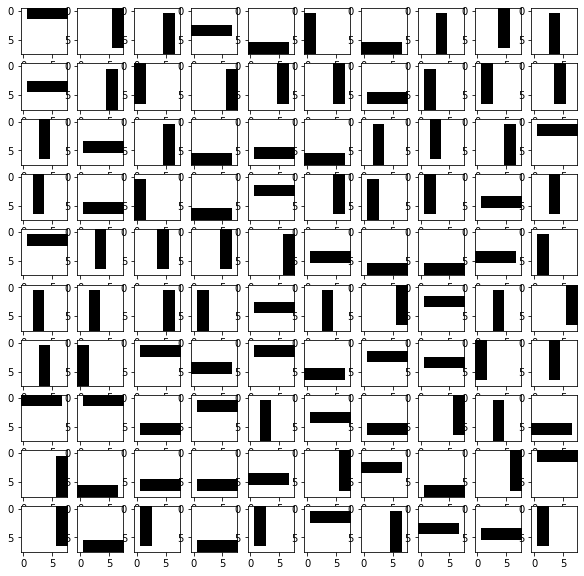


Information about the dataset : 
We have 183.0 images with label = 1 and 177.0 images with label = 0



In [16]:
# =========== Setting dataset ================
#1 xor
#2 quadrados e circulos
#3 retangulos verticais e horizontais

def import_dataset(name):

    if(name == "1"):
        Xt = np.array([ [0,0],[1,0],[0,1],[1,1]])
        Yt = np.array([0,1,1,0]).reshape(1,4)
    elif(name == "2"):
        N,n_row,n_col,data=read_asc_data('dataSets/square_circle.txt')
    elif(name == "3"):
        N,n_row,n_col,data=read_asc_data('dataSets/line600.txt')


    if(name != "1"):
        
        print('find %d images of %d X %d pixels' % (N,n_row,n_col))
        
        #Faz plot do dataset
        plot_data(10,10,n_row,n_col,data)
        
        Nt=int(N*0.6);
        Nval=int(N*0.2);
        I=n_row*n_col; 
        
        
        #split training vs test sets

        Xt=data[:Nt,:-1]
        Yt=data[:Nt,-1]
        Xval=data[Nt:Nval+Nt,:-1]
        Yval=data[Nt:Nval+Nt,-1]

        Yt = Yt.reshape(len(Yt),1)
        Yval=Yval.reshape(len(Yval),1)

        #replace 0 for -1
        np.place(Yt, Yt!=1, [0])
        np.place(Yval, Yval!=1, [0])

        m = Xt.shape[0]

        Xt = Xt.T
        Yt = Yt.T
        Xval=Xval.T
        Yval=Yval.T

        #test set
        Ne=N-Nt;
        Xe=data[Nt:N,:-1];Ye=data[Nt:N,-1];
        Ye = np.where(Ye == -1, 0,1)
        #plot_tagged_data(10,10,n_row,n_col,Xe,Ye,parameters)


        print("\nInformation about the dataset : ")
        print("We have " + str(np.sum(Yt)) + " images with label = 1 and " + str(Yt.shape[1]-np.sum(Yt)) + " images with label = 0\n")
        
        #print(Xt.shape)
        #print(Yt.shape)
        #print(Xe.shape)
        #print(Ye.shape)
        
        return Xt,Yt,Xval,Yval,Xe,Ye
    
    return Xt.T,Yt,_,_,_,_

#Xt,Yt,Xval,Yval,Xe,Ye = import_dataset("1") #xor
#Xt,Yt,Xval,Yval,Xe,Ye = import_dataset("2")#circulos
Xt,Yt,Xval,Yval,Xe,Ye = import_dataset("3")#retangulos

In [17]:
def xor_model(n_h,epochs,learning_rate,activation,show_info=True):

    
    parameters = inicializar_parameters(Xt.shape[0],n_h,Yt.shape[0],xor=False);
    
    
    #previous_cost vai ser similar a um eraly stopping neste problema, qd o custo não diminuir em 100 epochs para de treinar
    previous_cost = 1e3
    cost_arr=[]
    acc_train = []
    
    
    for i in range(0,epochs):
        
        A2, cache = feed_forward(Xt,parameters,activation);
        grads = back_propagation(Xt,Yt,cache,parameters,activation);
        parameters = otimize_parameters(parameters,grads,learning_rate);  
        
        
        
        if(i%1000 == 0):
            print(parameters["w1"])
            #validation cost calcultated here
            A2_train, _ = feed_forward(Xt,parameters,activation);
            print(A2_train)
        
            A2_plot = np.where(A2_train >= 0.5, 1 , 0)
            
            accuracy_train = np.sum(np.equal(A2_plot,Yt))/(A2_train.shape[1])
        
            
            acc_train.append(accuracy_train)
        
            
            
            cost = calculate_cost(A2_train,Yt)
            if(show_info == True):
                print("Cost of iteration " + str(i) + " = " + str(cost) + " and accuracy train of = " + str(accuracy_train));
        

            
            #parar se o cost em 100 iterações doir maior ao igual que o de -100 iterações
            if(accuracy_train == 1):
                break

            previous_cost = cost
            cost_arr.append(cost)
            
    
    if(show_info == True):
        figure(figsize=(15, 5))
        #primeiros dois números são as shapes,  linha e coluna, 3 index é onde está o gráfico
        plt.subplot(1, 2, 1)
        plt.plot(cost_arr)
        plt.title('model cost')
        plt.ylabel('loss')
        plt.xlabel('Epochs')
        plt.legend(['train'], loc='upper left')
    

        plt.subplot(1, 2, 2)    
        plt.plot(acc_train)
        plt.title('model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train'], loc='upper left')
        plt.show()
    
    return cache,parameters,times,accuracy_train,i

## Este é um modelo à parte para o Xor

In [18]:
n_h = 3
epochs = 300000
learning_rate = 0.01
#só com a relu é que está a funcionar wtf
activation = "relu"
#cache,parameters,times,accuracy_train,i = xor_model(n_h,epochs,learning_rate,activation)

Cost of iteration 0 = 0.6931437971782447 and accuracy train of = 0.5416666666666666
Cost of validation iteration 0 = 0.6930942005157895 and accuracy val of = 0.5666666666666667
Cost of iteration 100 = 0.6926193570230676 and accuracy train of = 0.5083333333333333
Cost of validation iteration 100 = 0.6917757770675965 and accuracy val of = 0.5416666666666666
Cost of iteration 200 = 0.6881061468471215 and accuracy train of = 0.6166666666666667
Cost of validation iteration 200 = 0.6892842282642752 and accuracy val of = 0.6083333333333333
Cost of iteration 300 = 0.6552340140688375 and accuracy train of = 0.7916666666666666
Cost of validation iteration 300 = 0.6725722945359333 and accuracy val of = 0.7666666666666667
Cost of iteration 400 = 0.48370013846694365 and accuracy train of = 0.8916666666666667
Cost of validation iteration 400 = 0.5218918688858308 and accuracy val of = 0.8666666666666667
Cost of iteration 500 = 0.33159897980352854 and accuracy train of = 0.9083333333333333
Cost of val

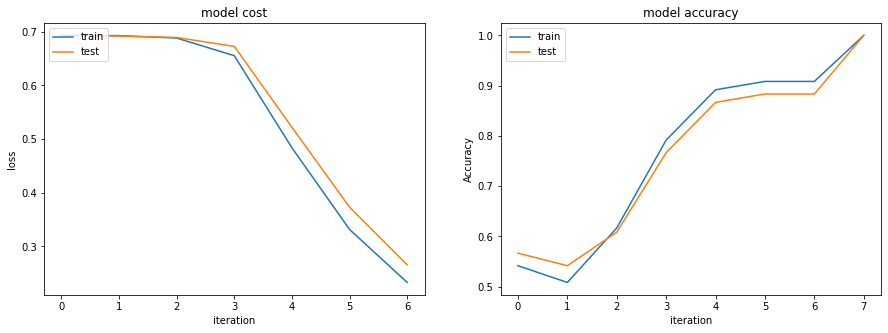

In [19]:
hidden_nodes= 5
epochs = 14000
cache,parameters,times,acc_train,acc_val,iterations = model(hidden_nodes,epochs,0.01,"tanh",32,True)

In [16]:
#funções de ativação disponíveis por agora
# * Relu
# * Tanh
# * Sigmoid
# * Leaky_Relu
# * Swish

def activation_time(hidden_nodes):
    
    activations_time = []
    accuracys = []
    iterations = []
    
    activations = ["swish","relu","sigmoid","leaky_relu","tanh"]
    
    for activation in activations:
        
        cache,parameters, times, acc_train, acc_val, iters = model(hidden_nodes,30000,0.01,activation,32,False)
    
        activations_time.append(np.mean(times))
        accuracys.append([acc_train,acc_val])
    
        iterations.append(iters)
    
    return activations_time,accuracys,iterations, activations


activations_time_1, accuracy1, iterations1, activations = activation_time(1)
activations_time_2, accuracy2, iterations2, activations = activation_time(3)
activations_time_3, accuracy3, iterations3, activations = activation_time(3)
activations_time_4, accuracy4, iterations4, activations = activation_time(40)
activations_time_5, accuracy5, iterations5, activations = activation_time(100)

In [30]:
np.array(accuracy1)[:,[1]]

array([0.8])

Activations = ['swish', 'relu', 'sigmoid', 'leaky_relu', 'tanh']


Text(0.5, 1.0, 'Accuracy atingidida em cada um dos modelos')

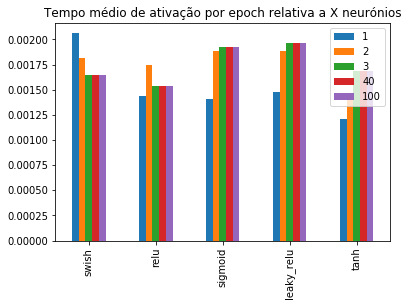

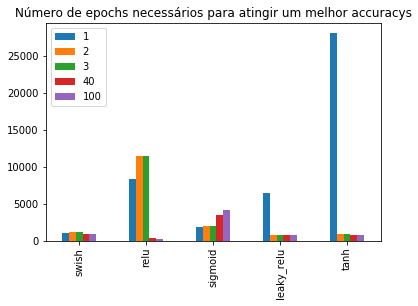

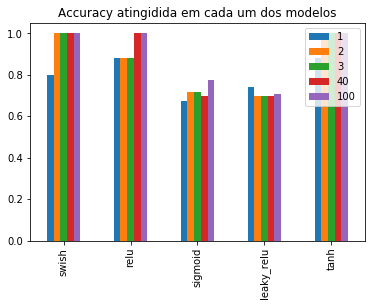

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("Activations = " + str(activations))

X = activations

#Tempos por epoch de cada ativação
A1 = activations_time_1
A2 = activations_time_2
A3 = activations_time_3
A4 = activations_time_3
A5 = activations_time_3

#Número de iterações para cada modelo chegar à sua melhor gráfico
I1 = iterations1
I2 = iterations2
I3 = iterations3
I4 = iterations4
I5 = iterations5

#Accuracy que cada modelo obteve
Ac1 = np.array(accuracy1)[:,[1]]
Ac2 = np.array(accuracy2)[:,[1]]
Ac3 = np.array(accuracy3)[:,[1]]
Ac4 = np.array(accuracy4)[:,[1]]
Ac5 = np.array(accuracy5)[:,[1]]



df1 = pd.DataFrame(np.c_[A1,A2,A3,A4,A5], index = X)
ax = df1.plot(kind='bar')
ax.legend(["1", "2", "3", "40","100"])
ax.set_title("Tempo médio de ativação por epoch relativa a X neurónios")


df2 = pd.DataFrame(np.c_[I1,I2,I3,I4,I5], index = X)
ax = df2.plot(kind='bar')
ax.legend(["1", "2", "3", "40", "100"])
ax.set_title("Número de epochs necessários para atingir a melhor accuracy")

df3 = pd.DataFrame(np.c_[Ac1,Ac2,Ac3,Ac4,Ac5], index = X)
ax = df3.plot(kind='bar')
ax.legend(["1", "2", "3", "40", "100"])
ax.set_title("Accuracy atingidida em cada um dos modelos")

(5, 64)
(1, 5)
***** ***** First Layer ***** *****


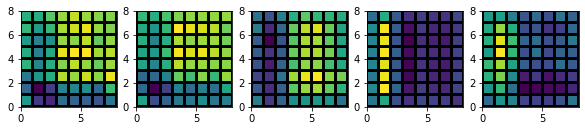

***** ***** *****  *****
[[ 0.61758987  0.80087453  0.88822456  3.05751762 -0.65808422]]


***** ***** Second Layer ***** *****


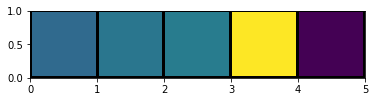

***** ***** *****  *****


In [45]:
#caso os pesos sejam maiores que 0.5 digo que é 1 caso contrário 0
def plot_weights(parameters,img_size):
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    
    print(w1.shape)
    print(w2.shape)
    
    img = w1.reshape(hidden_nodes,img_size,img_size)
    
    plt.ion()
    plt.figure(figsize=(10, 10))
    
    print("***** ***** First Layer ***** *****")
    for i in range(hidden_nodes):
        ax = plt.subplot(1, hidden_nodes, i + 1)
        plt.pcolormesh(img[i], edgecolors='k', linewidth=2)
        ax = plt.gca()
        ax.set_aspect('equal')         
    
        
    plt.show(block=True)
    print('***** ***** *****  *****')

    print(w2)
    print("\n\n***** ***** Second Layer ***** *****")
    
    plt.ion()
    plt.pcolormesh(w2, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    print('***** ***** *****  *****')    

plot_weights(parameters,8)

(5, 1)
[[-0.0246691 ]
 [ 0.09993247]
 [ 0.4330971 ]
 [ 1.93436737]
 [ 0.29841007]]
This is the Z for the = 1.0 output
***** ***** First Layer ***** *****


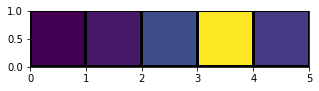

***** ***** *****  *****


***** ***** Second Layer ***** *****
[[2.37142798]]


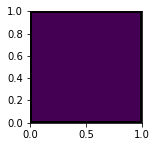

***** ***** *****  *****
(5, 1)
[[ 0.16626082]
 [ 0.22203769]
 [ 1.59992638]
 [-1.85824077]
 [-0.64739954]]
This is the Z for the = 0.0 output
***** ***** First Layer ***** *****


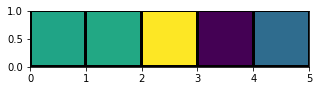

***** ***** *****  *****


***** ***** Second Layer ***** *****
[[-2.23902774]]


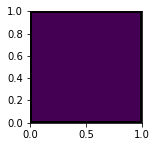

***** ***** *****  *****


In [46]:
def plot_Z_per_input(input_image,parameters,output):
    
    A2, cache = feed_forward(input_image,parameters,"tanh");
    
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    print(Z1.shape)
    print(Z1)
    
    plt.ion()
    plt.figure(figsize=(5, 5))
    
    print("This is the Z for the = " + str(output) + " output")
    
    print("***** ***** First Layer ***** *****")
    
    plt.ion()
    plt.pcolormesh(Z1.T, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    
    print('***** ***** *****  *****')
    
    plt.figure(figsize=(2, 3))
    print("\n\n***** ***** Second Layer ***** *****")
    print(Z2)
    
    plt.ion()
    plt.pcolormesh(Z2, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.set_aspect('equal')         
    plt.show(block=True)
    plt.pause(0.001)
    print('***** ***** *****  *****')    

x = Xt[:,3].reshape(Xt[:,0].shape[0],1)
y = Yt[:,3][0]

plot_Z_per_input(x,parameters,y)


x = Xt[:,2].reshape(Xt[:,0].shape[0],1)
y = Yt[:,2][0]
plot_Z_per_input(x,parameters,y)

In [26]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

def my_confusion_matrix(parameters,Xe,Ye):
    
    Ne=N-Nt;
    Xe=data[Nt+Nval:N,:-1];Ye=data[Nt+Nval:N,-1]; 
    Ye = np.where(Ye == -1, 0,1)
    Xe = Xe.T; Ye = Ye.T #test set
    
    #Xt,Yt -> train set
    
    predictions_train_set , _ = feed_forward(Xt,parameters,activation_function)
    predictions_test_set , _ = feed_forward(Xe,parameters,activation_function)
    predictions_train_set = np.where(predictions_train_set < 0.5 , 0 , 1) 
    predictions_test_set = np.where(predictions_test_set < 0.5 , 0 , 1) 
    
    labels = [0,1]
    columns = ['True','False']
    
    print("----------  Confusion matrix on train set with " + str(Yt.shape[1]) + " images ------------")
    
    #data
    y_test = Yt.T
    predic = predictions_train_set.T

    #confusion matrix
    confm = confusion_matrix(y_test, predic,labels)
    #confusion matrix to datafram
    df_cm = DataFrame(confm, index=columns, columns=columns)
    df_cm.plot(figsize=(6,3));
    
    #plot
    ax = sn.heatmap(df_cm, annot=True)
    plt.show()
    #same thing on test set
    print("----------  Confusion matrix on test set with " + str(Ye.shape[0]) + " ------------")
    y_test = Ye.T
    predic = predictions_test_set.T
    
    confm = confusion_matrix(y_test, predic)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    df_cm.plot(figsize=(6,3));
    ax = sn.heatmap(df_cm, annot=True)
    
my_confusion_matrix(parameters)

TypeError: my_confusion_matrix() missing 2 required positional arguments: 'Xe' and 'Ye'

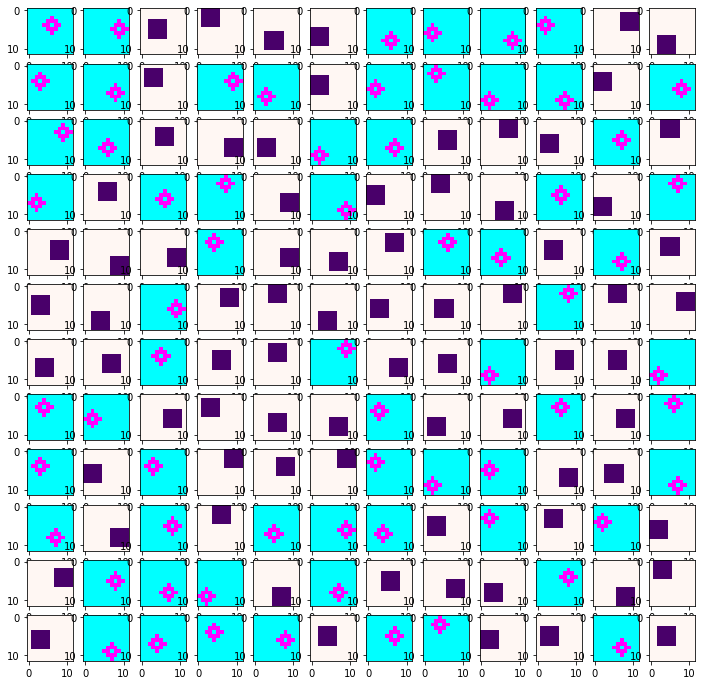

In [31]:
def plot_dataset(name,activation_function):
    
    if(name == "2"):
        N,n_row,n_col,data=read_asc_data('dataSets/square_circle.txt')
        plot_tagged_data(12,12,n_row,n_col,Xe,Ye,parameters,"relu")
    elif(name == "3"):
        N,n_row,n_col,data=read_asc_data('dataSets/line600.txt')
        plot_tagged_data(12,12,n_row,n_col,Xe,Ye,parameters,"relu")
    
plot_dataset("2","relu")